In [1]:
from astropy.table import Table, Column
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm          
sys.path.insert(0, '/home/reza/erq/')
from erqml import *
import os
from  sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde


/home/reza/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [20]:
# Reading data
# smp=Table.read('/home/reza/erq/sampling/org_sample2.fits')
smp=Table.read('/home/reza/erq/sampling/LM_sample.fits')
iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
iz_0 = iW3_0 - smp['r-w3'] + smp['r-z']

data_0 = np.array(list(zip(iW3_0, rew_0, kt80_0, frat_0)))
# Scaling data with mean and std
data,minData,rangeData = MinMaxScaler(data_0)
MainCenter= np.median(data, axis=0)
x,y,z, w= data.T
# finding ERQs
ERQ = data[((iW3_0>4.6) & (rew_0>2))]
nonERQ = data[((iW3_0<4.6) | (rew_0<2))]
#  ERQ center
erqCenter= np.median(ERQ, axis=0)
#  distance of ERQ centroid from the main population centeriod 
r_erq = np.linalg.norm(erqCenter-MainCenter)
# unit vector to ERQs center from MCL
u_erq = erqCenter - MainCenter
u_erq = u_erq/np.linalg.norm(u_erq)
# building random vector pool on unit vectors for choosing those that make an angle of Omega with ERQ vector
nPool=500000
l=np.linspace(-1,1,nPool)
u_x = np.random.choice(l, nPool)
u_y = np.random.choice(l, nPool)
u_z = np.random.choice(l, nPool)
u_w = np.random.choice(l, nPool)
v = np.array(list(zip(u_x,u_y,u_z, u_w)))
v_normal = uniter(v)

# opening angle for a specific enclosing ratio
Omega, dummy =opening_angle_finder(ERQ=ERQ, Main_center=MainCenter, enclosing_ratio=0.75, resolution=10000)
print(np.rad2deg(Omega))

16.426093457441183


In [21]:
#  Creating directions which have a deviation less than or equa Omega from ERQ vector
ConeDirections=[]
for i in range(len(v_normal)):
    if(np.arccos(np.dot(v_normal[i], u_erq))<=Omega):
        ConeDirections.append(v_normal[i])
ConeDirections.append(u_erq)
ConeDirections=np.array(ConeDirections)
print(len(ConeDirections))

3361


In [22]:
# Cone vectors are vectors as long as erq vector extended length 
# vectors which we are going to calculate density along
extention=1.3
ConeVectors = ConeDirections*r_erq*extention + MainCenter


(array([  6.,  24.,  81., 137., 212., 337., 436., 586., 702., 840.]),
 array([ 0.        ,  1.64255177,  3.28510355,  4.92765532,  6.5702071 ,
         8.21275887,  9.85531065, 11.49786242, 13.14041419, 14.78296597,
        16.42551774]),
 <a list of 10 Patch objects>)

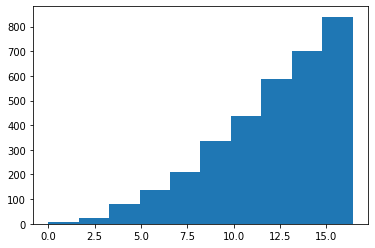

In [23]:
xf_cone, yf_cone, zf_cone, wf_cone= ConeVectors[:,0], ConeVectors[:,1], ConeVectors[:,2], ConeVectors[:,3]
angle=np.rad2deg(np.arccos(np.dot(ConeDirections,u_erq)))

plt.hist(angle)

In [24]:
print(np.nanmin(angle), np.nanmax(angle), np.rad2deg(Omega))

0.0 16.42551774215588 16.426093457441183


  0%|          | 2/3361 [00:00<04:35, 12.20it/s]

1


100%|██████████| 3361/3361 [06:12<00:00,  9.02it/s]


(3, 100)


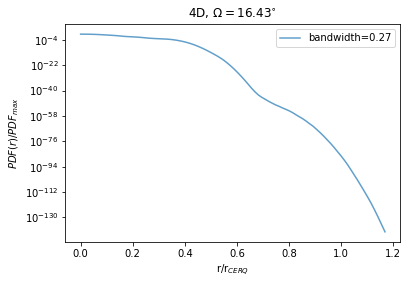

In [25]:
#   density in 3d  for different bandwidths
ngrid=100
den_med=np.zeros([3, ngrid])
# den_med = np.loadtxt('den-med-4d.txt')
j=-1
r = np.linspace(0,extention, ngrid)

for bw in [1]:
    j+=1
    kde= gaussian_kde(data.T)
    kde.set_bandwidth(bw_method=kde.factor*bw)
    den_max = max(kde(data.T))
    den_con=[]
    print(bw)
    for i in tqdm(range(len(xf_cone))):
        x=np.linspace(MainCenter[0],xf_cone[i], ngrid)
        y=np.linspace(MainCenter[1],yf_cone[i], ngrid)
        z=np.linspace(MainCenter[2],zf_cone[i], ngrid)
        w=np.linspace(MainCenter[3],zf_cone[i], ngrid)
        line = np.array(list(zip(x,y,z,w)))
        density= kde(line.T)
        den_con.append(density)
        

    den_med[j,:] = np.median(den_con, axis=0)
    print(den_med.shape)
    plt.semilogy(r[0:90], den_med[j,0:90]/den_max, alpha=0.7, label='bandwidth=%.2f' %(kde.factor*bw))
plt.legend()
plt.xlabel(r'r/r$_{CERQ}$')
plt.ylabel(r'$PDF(r)/PDF_{max}$')
plt.title(r'4D, $\Omega=%.2f^{\circ}$' %(np.rad2deg(Omega)))
plt.savefig('cone-4d-density-nTri%d.pdf' %(nPool))
# plt.show()
np.savetxt('den-med-4d.txt', den_med)

In [8]:
cp cone-4d-density-nTri200000.pdf ../../paper/fig/

In [16]:
min(den_med[1,:]/den_max)

2.0942787727437423e-131

In [11]:
den_max

446.51028956794283

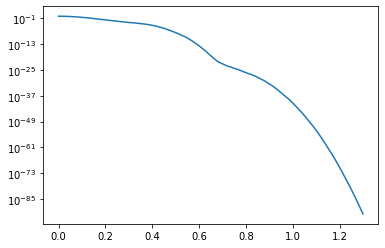

In [19]:
plt.semilogy(r, den_med[2,:]/den_max)

In [15]:
den_med[0,0]

547.0380673036794